In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from wbfm.utils.xinwei_fdnc.formatting import zimmer2leifer
from wbfm.utils.xinwei_fdnc.predict import load_fdnc_options_and_template, track_using_fdnc
import numpy as np
# Process into single set of matches
from scipy.optimize import linear_sum_assignment
import numpy as np
from scipy.sparse import coo_matrix


Bad key "text.kerning_factor" on line 4 in
/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from wbfm.utils.projects.finished_project_data import ProjectData
fname = "/scratch/zimmer/Charles/dlc_stacks/worm3-2021_09_29/project_config.yaml"
# fname = "/scratch/zimmer/Charles/dlc_stacks/project-pytest/project_config.yaml"
project_data = ProjectData.load_final_project_data_from_config(fname)

Project data for directory:
/scratch/zimmer/Charles/dlc_stacks/worm3-2021_09_29 
Found the following raw data files:
red_data: True
green_data: True
============Segmentation===============
raw_segmentation: True
segmentation: False
============Tracklets==================
df_training_tracklets: True
reindexed_masks_training: True
============Traces=====================
red_traces: False
green_traces: False
final_tracks: True
behavior_annotations: True



In [3]:
import pandas as pd
from collections import defaultdict
from tqdm.auto import tqdm
from fDNC.src.DNC_predict import pre_matt, predict_matches, filter_matches
from wbfm.utils.projects.utils_neuron_names import int2name
from wbfm.utils.xinwei_fdnc.formatting import flatten_nested_list

def track_using_fdnc_ONLY_TRAINING(project_dat: ProjectData,
                                   template_pos,
                                   prediction_options,
                                   match_confidence_threshold,
                                   num_frames):
    # Loop through detections and match all to template

    # Initialize
#     num_frames = project_dat.num_frames - 1
    coords = ['z', 'x', 'y', 'likelihood']

    sz = (num_frames, len(coords))
    neuron_arrays = defaultdict(lambda: np.zeros(sz))
    all_matches = []
    for i_frame in tqdm(range(num_frames), total=num_frames, leave=False):

        pts = project_dat.get_centroids_as_numpy_training(i_frame)
        pts_scaled = zimmer2leifer(pts)
        # Match
        _, matches = predict_matches(test_pos=pts_scaled, template_pos=template_pos, **prediction_options)
        matches = flatten_nested_list(matches)
        matches = filter_matches(matches, match_confidence_threshold)

        # For each match, save location
        for m in matches:
            this_unscaled_pt = pts[m[1]]
            this_template_idx = m[0]

            neuron_arrays[this_template_idx][i_frame, :3] = this_unscaled_pt
            neuron_arrays[this_template_idx][i_frame, 3] = m[2]  # Match confidence
        all_matches.append(matches)

    # Convert to pandas multiindexing formatting
    new_dict = {}
    for i_template, data in neuron_arrays.items():
        for i_col, coord_name in enumerate(coords):
            # Note: these neuron names are final for all subsequent steps
            k = (int2name(i_template + 1), coord_name)
            new_dict[k] = data[:, i_col]

    df = pd.DataFrame(new_dict)

    return df, all_matches

def generate_template(i):
    custom_template = project_data.get_centroids_as_numpy_training(i)
    return zimmer2leifer(custom_template)

In [4]:
num_templates = project_data.reindexed_metadata_training.num_frames
all_templates = [generate_template(i) for i in range(num_templates)]

base_prediction_options, _, _ = load_fdnc_options_and_template()
base_prediction_options['topn'] = 3

match_confidence_threshold = 0.3

In [5]:
df_per_template = []
matches_per_template = []
for template in tqdm(all_templates):
    df, matches = track_using_fdnc_ONLY_TRAINING(project_data, template, base_prediction_options, match_confidence_threshold, num_frames=num_templates)
    df_per_template.append(df)
    matches_per_template.append(matches)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

# Visualize

In [6]:
# Note: the second index in the match is the template
# Combine the matches from each template by summing the confidence

# First, convert each to a sparse matrix
# i_match = 0
all_final_conf = []
all_individual_conf = []
shape = (130, 130)

for i_match in range(num_templates):
    all_conf = []

    for i_template in range(num_templates):
        m = np.array(matches_per_template[i_template][i_match])
        row, col, data = m[:,0], m[:,1], m[:,2]
    #     shape = (int(max(row))+1, int(max(col))+1)
        conf = coo_matrix((data, (row, col)), shape=shape, dtype=float)
        all_conf.append(conf)
    final_conf = sum(all_conf)
    
    all_individual_conf.append(all_conf)
    all_final_conf.append(final_conf)
#     other_frame_conf = sum(all_conf[1:])


In [7]:
from ipywidgets import interact
def f(i_test):
    %matplotlib inline
    plt.figure(figsize=(25, 15))
    plt.imshow(all_final_conf[i_test].toarray())
    plt.title("Accuracy all templates")
    plt.colorbar()
    
    plt.show()

interact(f, i_test=(0,9))

interactive(children=(IntSlider(value=4, description='i_test', max=9), Output()), _dom_classes=('widget-intera…

<function __main__.f(i_test)>

# Just look at bipartite matching

In [10]:
from wbfm.utils.feature_detection.utils_networkx import calc_bipartite_from_candidates

In [28]:
m = matches_per_template[9]
m = flatten_nested_list(m)
m = np.array(m)
m[:,2] /= 10
matches, conf, _ = calc_bipartite_from_candidates(m, min_conf=0.1)
[(m[0],m[1], c) for m, c in zip(matches, conf)];

In [34]:
from wbfm.utils.performance.comparing_ground_truth import calc_summary_scores_for_training_data

In [40]:
for i in range(10):
    m = matches_per_template[i]
    m = flatten_nested_list(m)
    m = np.array(m)
    m[:,2] /= 10
    matches, conf, _ = calc_bipartite_from_candidates(m, min_conf=0.1)
    m_final = [(m[0],m[1], c) for m, c in zip(matches, conf)]

    num_tp, num_outliers, num_missing, max_possible = calc_summary_scores_for_training_data(m_final)

    print(f"For pose {i}, tp: {num_tp / max_possible: .2f}, outliers: {num_outliers / max_possible: .2f}")

For pose 0, tp:  1.00, outliers:  0.00
For pose 1, tp:  1.00, outliers:  0.00
For pose 2, tp:  1.00, outliers:  0.00
For pose 3, tp:  1.00, outliers:  0.00
For pose 4, tp:  1.00, outliers:  0.00
For pose 5, tp:  1.00, outliers:  0.00
For pose 6, tp:  0.96, outliers:  0.03
For pose 7, tp:  0.93, outliers:  0.04
For pose 8, tp:  0.89, outliers:  0.06
For pose 9, tp:  0.75, outliers:  0.15


In [32]:
max_possible


119

In [33]:
num_tp

120

# Frame - number of template tradeoffs

In [57]:
from wbfm.utils.training_data.tracklet_to_DLC import get_or_recalculate_which_frames
from wbfm.utils.visualization.visualization_tracks import hist_of_tracklet_lens,plot_tracklets_of_min_len,plot_tracklet_covering

In [41]:
df_raw_matches = project_data.raw_matches

/home/charles/anaconda3/envs/torch/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator GaussianProcessRegressor from version 1.0 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [48]:
df_clust = project_data.raw_clust

In [43]:
num_frames = project_data.project_config.config['dataset_params']['num_frames']
DEBUG = False
training_cfg= project_data.project_config.get_training_config()

In [46]:
which_frames = list(
            get_or_recalculate_which_frames(DEBUG, df_raw_matches, num_frames,
                                            training_cfg))

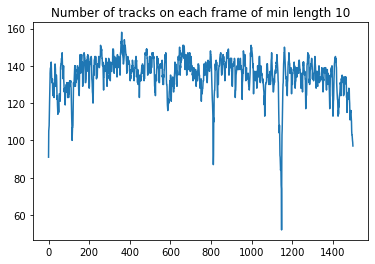

In [55]:
plot_tracklets_of_min_len(df_clust, min_len=10);

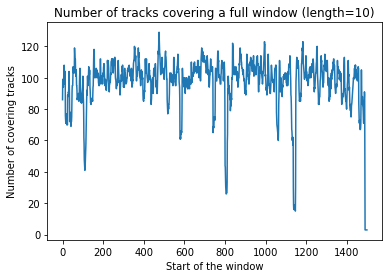

129

In [74]:
out = plot_tracklet_covering(df_clust, window_len=10)

np.max(out[1])